In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import plotly.express as px

Mounted at /content/drive


In [ ]:
moths = pd.read_csv('/content/drive/My Drive/Moths!/moth_data.csv',   sep='\t')

<ipython-input-22-c58ce345869f>:1: DtypeWarning: Columns (10,39,46) have mixed types. Specify dtype option on import or set low_memory=False.
  moths = pd.read_csv('/content/drive/My Drive/Moths!/moth_data.csv',   sep='\t')


In [ ]:
moths.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

In [ ]:
location_groups = moths.groupby(['decimalLatitude', 'decimalLongitude'])
biodiversity_counts = location_groups['species'].nunique().reset_index(name='biodiversity')

In [ ]:

fig = px.density_mapbox(biodiversity_counts,
                        lat='decimalLatitude',
                        lon='decimalLongitude',
                        z='biodiversity',
                        radius=10,  # You can adjust the radius to change the area considered for each point
                        center=dict(lat=biodiversity_counts['decimalLatitude'].mean(), lon=biodiversity_counts['decimalLongitude'].mean()),
                        zoom=6,  # Adjust the zoom level
                        mapbox_style="stamen-terrain"  # Choose a map style
                        )

fig.show()

In [ ]:
# Define the size of the boxes (change as needed)
import matplotlib.pyplot as plt
import numpy as np

# Define the size of the boxes
box_size= 0.05
lat_bins = np.arange(moths['decimalLatitude'].min(), moths['decimalLatitude'].max(), box_size)
lon_bins = np.arange(moths['decimalLongitude'].min(), moths['decimalLongitude'].max(), box_size)

# Bin the latitude and longitude
moths['lat_bin'] = pd.cut(moths['decimalLatitude'], bins=lat_bins)
moths['lon_bin'] = pd.cut(moths['decimalLongitude'], bins=lon_bins)

# Group by the binned latitude and longitude and count unique species
box_groups = moths.groupby(['lat_bin', 'lon_bin'])
biodiversity_counts = box_groups['species'].nunique().reset_index(name='biodiversity')

# Get the center of each bin for plotting
biodiversity_counts['lat'] = biodiversity_counts['lat_bin'].apply(lambda x: (x.left + x.right) / 2)
biodiversity_counts['lon'] = biodiversity_counts['lon_bin'].apply(lambda x: (x.left + x.right) / 2)

# Plot the heatmap on a map using Plotly
fig = px.density_mapbox(biodiversity_counts,
                        lat='lat',
                        lon='lon',
                        z='biodiversity',
                        radius=10,
                        center=dict(lat=0, lon=0),
                        zoom=0,
                        mapbox_style="stamen-terrain")
fig.show()

TypeError: ignored

In [ ]:
import plotly.graph_objects as go
# Define the size of the boxes
lat_bins = np.arange(moths['decimalLatitude'].min(), moths['decimalLatitude'].max(), 0.5)
lon_bins = np.arange(moths['decimalLongitude'].min(), moths['decimalLongitude'].max(), 0.5)

# Bin the latitude and longitude
moths['lat_bin'] = pd.cut(moths['decimalLatitude'], bins=lat_bins)
moths['lon_bin'] = pd.cut(moths['decimalLongitude'], bins=lon_bins)

# Group by the binned latitude and longitude and count unique species
box_groups = moths.groupby(['lat_bin', 'lon_bin'])
biodiversity_counts = box_groups['species'].nunique().reset_index(name='biodiversity')

def bin_to_geojson(bin_lat, bin_lon, biodiversity):
    return {
        'type': 'Feature',
        'geometry': {
            'type': 'Polygon',
            'coordinates': [[
                [bin_lon.left, bin_lat.left],   # bottom left corner
                [bin_lon.left, bin_lat.right],  # top left corner
                [bin_lon.right, bin_lat.right], # top right corner
                [bin_lon.right, bin_lat.left],  # bottom right corner
                [bin_lon.left, bin_lat.left],   # back to bottom left corner
            ]]
        },
        'properties': {'biodiversity': biodiversity},
    }
# Create a list of geojson-formatted features
features = [
    bin_to_geojson(row['lat_bin'], row['lon_bin'], row['biodiversity'])
    for _, row in biodiversity_counts.iterrows()
]

# Create a geojson object
geojson = {'type': 'FeatureCollection', 'features': features}

# Create the choropleth map
fig = go.Figure(go.Choroplethmapbox(
    geojson=geojson,
    locations=list(range(len(features))),  # Use indices as location ids
    z=biodiversity_counts['biodiversity'],
    colorscale="Viridis",
    marker_opacity=0.6,
    marker_line_width=0
))

# Update map layout
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=1,
    mapbox_center={"lat": 0, "lon": 0}
)

# Show the map
fig.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



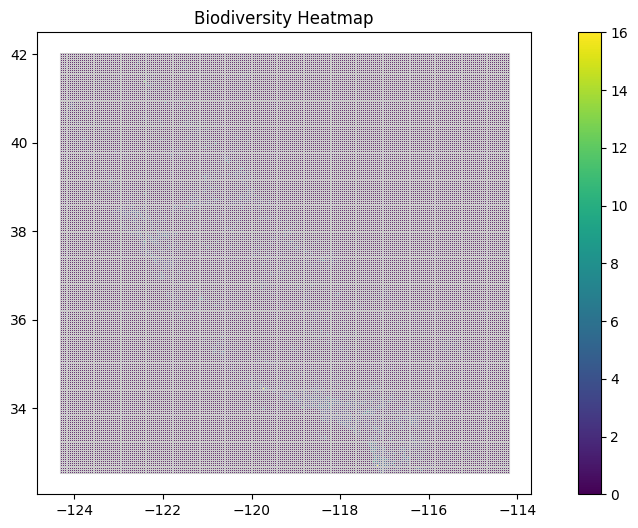

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Approximate bin size in degrees for 3 miles
bin_size = 0.0435  # Adjust as needed

# Create a grid of polygons (bins)
min_lon, max_lon = moths['decimalLongitude'].min(), moths['decimalLongitude'].max()
min_lat, max_lat = moths['decimalLatitude'].min(), moths['decimalLatitude'].max()
lons = np.arange(min_lon, max_lon, bin_size)
lats = np.arange(min_lat, max_lat, bin_size)
polygons = []
for lon in lons:
    for lat in lats:
        polygons.append(Polygon([(lon, lat), (lon+bin_size, lat), (lon+bin_size, lat+bin_size), (lon, lat+bin_size)]))
grid = gpd.GeoDataFrame({'geometry': polygons})

# Convert moths DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(moths['decimalLongitude'], moths['decimalLatitude'])
moths_gdf = gpd.GeoDataFrame(moths, geometry=geometry)

# Spatially join points and polygons
joined = gpd.sjoin(moths_gdf, grid, op='within')

# Count unique species in each bin
biodiversity_counts = joined.groupby('index_right')['species'].nunique().reset_index(name='biodiversity')
grid['biodiversity'] = grid.index.map(biodiversity_counts.set_index('index_right')['biodiversity']).fillna(0)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
grid.plot(column='biodiversity', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Biodiversity Heatmap')
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# Assuming `grid` is the GeoDataFrame created in the previous step
# Compute the centroids of the polygons to use as the locations for the heatmap
grid['lon'] = grid['geometry'].centroid.x
grid['lat'] = grid['geometry'].centroid.y

# Initialize a folium map centered at the mean latitude and longitude of your grid
m = folium.Map(location=[grid['lat'].mean(), grid['lon'].mean()], zoom_start=4)

# Convert biodiversity, lat, and lon to a numpy array, then to a list of lists
heat_data = grid[['lat', 'lon', 'biodiversity']].to_numpy()
heat_data = heat_data.tolist()

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Show the map
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Getting unique species
unique_species = moths['species'].unique()

# Counting the number of unique species
num_unique_species = len(unique_species)

# Displaying the unique species and their count
print(f'Number of Unique Species: {num_unique_species}')
print(f'Unique Species: {unique_species}')


Number of Unique Species: 41
Unique Species: ['Hyles lineata' 'Sphinx perelegans' 'Hemaris thetis' 'Eumorpha achemon'
 'Manduca sexta' 'Proserpinus clarkiae' 'Proserpinus lucidus'
 'Euproserpinus phaeton' 'Sphinx vashti' 'Pachysphinx occidentalis'
 'Smerinthus cerisyi' 'Sphinx sequoiae' 'Agrius cingulata'
 'Sphinx chersis' 'Macroglossum stellatarum' 'Manduca rustica'
 'Sphinx drupiferarum' 'Erinnyis ello' 'Manduca quinquemaculatus'
 'Erinnyis crameri' 'Erinnyis alope' 'Erinnyis obscura' 'Cocytius antaeus'
 'Hemaris diffinis' 'Sphinx dollii' 'Paonias myops' 'Paonias excaecata'
 'Euproserpinus euterpe' 'Manduca jordani' 'Pachylia ficus' nan
 'Smerinthus ocellata' 'Arctonotus lucidus' 'Enyo lugubris'
 'Pachysphinx modesta' 'Aellopos clavipes' 'Smerinthus saliceti'
 'Sphinx leucophaeata' 'Sphinx luscitiosa' 'Proserpinus flavofasciata'
 'Hyles livornicoides']


In [ ]:
# Counting the occurrence of each unique species
species_counts = moths['species'].value_counts()

# Displaying the counts
print(species_counts)


Hyles lineata                9937
Manduca sexta                1748
Smerinthus cerisyi            930
Sphinx perelegans             644
Eumorpha achemon              480
Hemaris thetis                444
Proserpinus lucidus           427
Sphinx chersis                209
Proserpinus clarkiae          203
Manduca quinquemaculatus      176
Manduca rustica               173
Erinnyis ello                 155
Sphinx vashti                 126
Pachysphinx occidentalis      123
Sphinx sequoiae               108
Euproserpinus phaeton         103
Agrius cingulata               94
Erinnyis obscura               72
Cocytius antaeus               71
Hemaris diffinis               62
Sphinx drupiferarum            24
Arctonotus lucidus             21
Paonias myops                  15
Paonias excaecata              12
Sphinx leucophaeata            12
Erinnyis crameri               11
Macroglossum stellatarum       11
Euproserpinus euterpe           8
Sphinx dollii                   6
Smerinthus sal